## Air quality analysis and prediction

The dataset comes is taken from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality). 

The target variable corresponds to the first column CO(GT) variable. 
The roadmap: 
1. data preprocessing, 
2. model training
3. testing and validation. 

Testing data for validation is set aside before any preprocessing. 

### Data preprocessing

* Split the data into training and testing sets 
* Remove the rows with missing target (for supervised learning, all the targets should be known) 
* Remove features with more than 20% of missing values. 
* Replace all the other missing values with the mean value of the non-missing values for imputation.
* Normalise the data by substracting the mean value for each feature and dividing the result by the standard deviation of each feature

Normalisation puts all feature values in one range which speeds up convergence of different algorithms for finding of optimal parameters of a model. 
### Model validation
* Perform similar data preprocessing for the test data:
- Remove the rows of the test data for which the labels have missing values. 
- Remove the same features that were removed for the train data
- Replace the missing values on each feature variables with the mean values computed for the training data.
* Normalise the test data using the means and standard deviations computed from the training data
* Compute again $\mathbf{w}$ for the value of $\alpha$ that best performed on the validation set using ALL the training data (not all the training set).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pods
pods.util.download_url('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip')
import zipfile
zip = zipfile.ZipFile('./AirQualityUCI.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

[===========================   ]   1.328/1.472MB

[==============================]   1.472/1.472MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


In [2]:
# The .csv version of the file has some typing issues, so we use the excel version
import pandas as pd 
air_quality = pd.read_excel('AirQualityUCI.xlsx', usecols=range(2,15))

In [3]:
air_quality.sample(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
749,2.5,1219.75,235,9.711401,966.75,174.0,843.50,117.0,1545.00,1218.50,11.825,56.625000,0.783266
3723,1.3,1008.25,-200,7.498693,878.25,53.0,792.00,67.0,1690.75,722.00,29.300,50.174999,2.012723
4439,-200.0,1144.50,-200,9.823749,971.00,-200.0,882.50,-200.0,1418.25,758.75,34.200,22.625000,1.197010
2954,1.6,1010.50,-200,9.711401,966.75,111.0,818.00,116.0,1565.25,748.25,25.275,30.925000,0.981535
6296,-200.0,1046.25,-200,6.112196,817.00,-200.0,790.25,-200.0,1213.50,957.25,10.500,78.600000,0.997560


In [4]:
import numpy as np
np.random.seed(123)

# Shuffle indexes and then select first 70% for train set
indexes = np.random.permutation(air_quality.index)
train_size = int(air_quality.shape[0]*0.7)
indexes_train = indexes[0:train_size]
indexes_test = indexes[train_size:]

air_quality_train = air_quality.iloc[indexes_train, :]
air_quality_test = air_quality.iloc[indexes_test, :]

# Checking shapes
print('Train set:',air_quality_train.shape[0], 'Test:', air_quality_test.shape[0])
print('Train set share:', round(air_quality_train.shape[0]/air_quality.shape[0], 3))
print('Train + test == all set:',(air_quality_train.shape[0]+air_quality_test.shape[0])==air_quality.shape[0])

Train set: 6549 Test: 2808
Train set share: 0.7
Train + test == all set: True


In [5]:
air_quality_test.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
5107,3.3,1430.25,-200,16.240066,1187.00,308.0,538.75,94.0,1811.50,1339.25,29.000,43.900001,1.730910
5369,-200.0,1631.00,-200,26.040876,1455.25,-200.0,437.75,-200.0,2026.75,1915.50,22.400,64.575002,1.727112
2979,1.5,903.50,-200,7.463303,876.75,117.0,890.00,95.0,1487.75,780.50,22.475,36.775001,0.988022
7547,-200.0,829.50,-200,0.925975,491.50,53.3,1263.00,52.0,948.00,577.50,4.725,78.949999,0.681963
6283,4.4,1561.75,-200,19.405954,1279.75,743.0,479.25,156.0,1711.25,1709.25,15.350,73.300001,1.269962


## Exploratory analysis and first Data preprocessing

In [6]:
# Exploratory analysis
print('Percent of missing values in row data')
for col in air_quality_train.columns:
    percent_missing = round(air_quality_train[air_quality_train[col]== -200].shape[0]*100/
                                                          air_quality_train.shape[0], 1)
    print(col, ':',percent_missing )

# Dropping rows with missing target values

rows_missing_target = air_quality_train[air_quality_train['CO(GT)']==-200].index
print('Removing', len(rows_missing_target),'rows with missing target values...')
air_quality_train.drop(rows_missing_target, axis=0, inplace=True)

# Dropping feature columns with more than 20% of missing values and replacement of other missing values
print('')
print('Dealing with missing data...')
print('')
for col in air_quality_train.columns[1:]:
    percent_missing = round(air_quality_train[air_quality_train[col]== -200].shape[0]*100/
                                                          air_quality_train.shape[0], 1)
    if percent_missing >20:
        print('')
        print("!!!!!!! Removing column:", col, 'Percent of missing values',percent_missing )
        air_quality_train.drop(columns = col, axis=1, inplace = True)
        print('')
    else:
        indexes_missing_rows = air_quality_train[air_quality_train[col] == -200].index
        mean_value = air_quality_train[air_quality_train[col] != -200][col].mean()
        
        print('Replacing', percent_missing,'% missing values in', col, 'with mean value', mean_value)
        for row in indexes_missing_rows:
            air_quality_train.loc[row][col] = mean_value

Percent of missing values in row data
CO(GT) : 17.7
PT08.S1(CO) : 4.0
NMHC(GT) : 90.3
C6H6(GT) : 4.0
PT08.S2(NMHC) : 4.0
NOx(GT) : 17.5
PT08.S3(NOx) : 4.0
NO2(GT) : 17.5
PT08.S4(NO2) : 4.0
PT08.S5(O3) : 4.0
T : 4.0
RH : 4.0
AH : 4.0
Removing 1160 rows with missing target values...

Dealing with missing data...

Replacing 4.4 % missing values in PT08.S1(CO) with mean value 1111.8475483537097

!!!!!!! Removing column: NMHC(GT) Percent of missing values 88.5

Replacing 4.4 % missing values in C6H6(GT) with mean value 10.376809371229857
Replacing 4.4 % missing values in PT08.S2(NMHC) with mean value 950.7347499838281
Replacing 5.4 % missing values in NOx(GT) with mean value 257.358073376496
Replacing 4.4 % missing values in PT08.S3(NOx) with mean value 824.5041884986092
Replacing 5.5 % missing values in NO2(GT) with mean value 115.00023552502452
Replacing 4.4 % missing values in PT08.S4(NO2) with mean value 1446.816611682515
Replacing 4.4 % missing values in PT08.S5(O3) with mean value 104

In [7]:
# Checking C6H6(GT) column - percent of replaced values

air_quality_train[air_quality_train['C6H6(GT)']== 10.29892670134189].shape[0]*100/air_quality_train.shape[0]

0.0

### Normalising the  data 

In [8]:
means_and_deviations = {}
for col in air_quality_train.columns[1:]: # the target variable doesn't need normalisation
    col_mean = air_quality_train.loc[:, col].mean()
    col_std = air_quality_train.loc[:, col].std()
    means_and_deviations[col]= [col_mean, col_std]
    air_quality_train.loc[:, col] = (air_quality_train.loc[:,col] - col_mean)/col_std

In [9]:
# Checking ranges
print(air_quality_train['PT08.S1(CO)'].min(), air_quality_train['PT08.S1(CO)'].max())
print(air_quality_train['RH'].min(), air_quality_train['RH'].max())

-3.6557802077435815 2.778421088490933
-2.330256193520676 2.3044418798754593


## Training and validation stages

In [10]:
# make feature and target vectors
y = air_quality_train['CO(GT)'].values
x = air_quality_train.drop(columns = ['CO(GT)'], axis=1).copy().values
# X = np.hstack((np.ones_like(x), x))
X = np.hstack((np.ones([x.shape[0],1]), x))

y.shape, x.shape, X.shape

((5389,), (5389, 11), (5389, 12))

## Training with closed form expression for $\mathbf{w}$ 

In [11]:
# Shuffle indexes and then select first 70% for train2 set from original train set
np.random.seed(123)

indexes_train = np.random.permutation(air_quality_train.index)
train2_size = int(air_quality_train.shape[0]*0.7)
indexes_train2 = indexes_train[0:train2_size]
indexes_valid = indexes_train[train2_size:]

air_quality_train2 = air_quality_train.loc[indexes_train2, :]
air_quality_valid = air_quality_train.loc[indexes_valid, :]

y_train2 = air_quality_train2['CO(GT)'].values
x_train2 = air_quality_train2.drop(columns = ['CO(GT)'], axis=1).copy().values
X_train2 = np.hstack((np.ones([x_train2.shape[0],1]), x_train2))

y_valid = air_quality_valid['CO(GT)'].values
x_valid = air_quality_valid.drop(columns = ['CO(GT)'], axis=1).copy().values
X_valid = np.hstack((np.ones([x_valid.shape[0],1]), x_valid))

In [12]:
X_train2.shape, X_valid.shape

((3772, 12), (1617, 12))

**Equation for computing** $\mathbf{w}$: 
$
[2\mathbf{X}^\top \mathbf{X} + \alpha^{.} nI]\mathbf{w} = 2\mathbf{X}^\top \mathbf{y}
$

In [13]:
# create a set of values of regularisation parameter in log scale
alphas_range = np.logspace(start=-3, stop=2, num=20)

In [14]:
import scipy as sp
from scipy import linalg

n_train2 = len(y_train2)
mse_valid = 0
mse_alphas = []
for alpha in alphas_range:
    
    sum_matrices = 2*np.dot(X_train2.T, X_train2) + alpha * n_train2* np.identity(X_train2.shape[1])
    w = sp.linalg.solve(sum_matrices, 2*np.dot(X_train2.T, y_train2))   
    
    predicted_valid = np.dot(X_valid, w)
    error = (y_valid - predicted_valid )**2
    mse_valid = error.mean()
    mse_alphas.append(mse_valid)

# The best alpha:
best_alpha = alphas_range[mse_alphas == np.array(mse_alphas).min()][0]
print('Minimum MSE for validation set among %s values is %s' %( len(mse_alphas), np.array(mse_alphas).min()))
print('The best alphas is %s' %(best_alpha))

Minimum MSE for validation set among 20 values is 0.2456507478352532
The best alphas is 0.001


#### Conclusion

The best value of $\alpha $ is 0.001 in the range from 0.001 to 100 which is lowest value in the whole studied range.
<br>The regularisation term is primarily used to improve generalisation property of a model to deal with unknown data.  The low value of alpha decreases effect of regularisation and brings us back to a classic linear model. The fact that we have chosen such a low alpha from the results of the model implimentation onto validation set which had not been used before, let us assume that a simple linear regression could also perform rather good on the studied air_quality data without overfitting it.

### Validation with the closed form expression for $\mathbf{w}$ 

In [15]:
# Removing rows with missing targets
rows_missing_target_test = air_quality_test[air_quality_test['CO(GT)']==-200].index
print('Removing', len(rows_missing_target_test),'rows with missing target values...')
air_quality_test.drop(rows_missing_target_test, axis=0, inplace=True)

Removing 523 rows with missing target values...


In [16]:
# Remove the same feature from test data, i.e. NMHC(GT) feature column
print('Removing "NMHC(GT)" column from test data...')
air_quality_test.drop('NMHC(GT)', axis=1, inplace=True)

Removing "NMHC(GT)" column from test data...


In [17]:
# Replacing missing values with mean found for training data
print('Checking missing data in C6H6(GT):', air_quality_test[air_quality_test['C6H6(GT)']== -200].shape[0])
for col in air_quality_test.columns[1:]:
    indexes_missing_rows = air_quality_test[air_quality_test[col] == -200].index
    mean_value = means_and_deviations[col][0]
    air_quality_test.loc[indexes_missing_rows, col] = mean_value

Checking missing data in C6H6(GT): 94


In [18]:
# Checking replacement
print('Missing data:', air_quality_test[air_quality_test['C6H6(GT)']== -200].shape[0])
print('Replaced data:', air_quality_test[air_quality_test['C6H6(GT)']== 10.29892670134189].shape[0])

# Checking columns in train and test data
len(air_quality_test.columns), len(air_quality_train.columns)

Missing data: 0
Replaced data: 0


(12, 12)

In [19]:
# Normalizing test data
for col in air_quality_test.columns[1:]:
    col_mean = means_and_deviations[col][0]
    col_std = means_and_deviations[col][1]
    air_quality_test.loc[:,col] = (air_quality_test.loc[:,col] - col_mean)/col_std

In [20]:
y_train = air_quality_train['CO(GT)'].values
x_train = air_quality_train.drop(columns = ['CO(GT)'], axis=1).copy().values

y_test = air_quality_test['CO(GT)'].values
x_test = air_quality_test.drop(columns = ['CO(GT)'], axis=1).copy().values

X_train = np.hstack((np.ones([x_train.shape[0],1]), x_train))
X_test = np.hstack((np.ones([x_test.shape[0],1]), x_test))

X_train.shape, X_train2.shape, X_test.shape

# Computing w for the value of 𝛼 using ALL the training data = X_train (not all the training set X_train2)

# Linear regression with regularisation
n_train = len(y_train)
alpha = best_alpha

sum_matrices = 2*np.dot(X_train.T, X_train) + alpha * n_train* np.identity(X_train.shape[1])
w_train = sp.linalg.solve(sum_matrices, 2*np.dot(X_train.T, y_train)) 

predicted_test = np.dot(X_test, w_train)
abs_error_reg = abs(y_test - predicted_test)
error_test_reg = abs_error_reg**2
mse_test_reg = error_test_reg.mean()

# Linear regression without regularisation
w_non_reg = np.linalg.solve(np.dot(X_train.T, X_train), np.dot(X_train.T, y_train))

predicted_test_non_reg = np.dot(X_test, w_non_reg)
abs_error_non_reg = abs(y_test - predicted_test_non_reg)
error_test_non_reg = abs_error_non_reg**2
mse_test_non_reg = error_test_non_reg.mean()

print('MSE on the preprocessed test data:', mse_test_reg)

MSE on the preprocessed test data: 0.23214832148574321


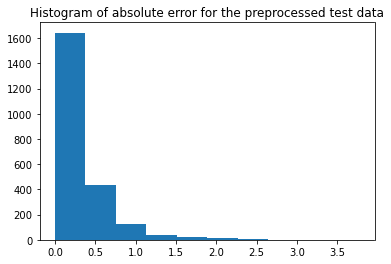

In [21]:
import pylab as plt
%matplotlib inline 

plt.hist(abs_error_reg, bins=10)
plt.title('Histogram of absolute error for the preprocessed test data');

In [22]:
print('Difference in MSE for models with regularisation and without it:', (mse_test_reg - mse_test_non_reg)*100/ mse_test_non_reg)

Difference in MSE for models with regularisation and without it: 0.006035353138057002


#### Conclusion
As it comes from our results, regularisation have led to a very little improvement of our model.
The best value of regularisation parameter which led to the lowest MSE values on validation set was found to be the lowest value in investigated range of alphas. In general, it means that our model might not need any regularisation at all. So it is not very surprising that the difference in MSE for models, trained on the whole train data with regularisation is just 0.08% better that the model without it.

## Training with gradient descent and validation 

#### Obective function : $ J(\mathbf{w}, \alpha) = \frac{1}n(Y - \mathbf{X}\mathbf{w})^{\top}(Y - \mathbf{X}\mathbf{w}) + \frac{\alpha}{2}\mathbf{w}^{\top} \mathbf{w} $

#### Update of $\mathbf{w}$ : $
\mathbf{w}_{\text{new}} = \mathbf{w}_{\text{old}} - \eta\frac{d J(\mathbf{w}, \alpha)}{d\mathbf{w}}= \mathbf{w}_{\text{old}}- \eta(-2\mathbf{X}(\mathbf{y} - \mathbf{X}\mathbf{w}) + \alpha^{.}\mathbf{w})
$

In [23]:
def SGD_minibatch(training_set, W, B = 100, learn_rate = 0.01, alpha=0.1, max_iter = 500, check_obj = 10):
    count_updates = 0
    obj_prev = None
    converge = False
    
    num_updates = []
    objectives = []
    
    indexes_train = np.random.permutation(training_set.index)
    indexes_minibatch = indexes_train[0:B]
    
    minibatch_train = training_set.loc[indexes_minibatch, :]
    
    for iteration in range(1,max_iter+1):
        #print('Iteration', iteration)
        if converge:
            break
        np.random.seed(123)
        np.random.shuffle(indexes_minibatch)
        for i in indexes_minibatch:
            if converge:
                break
            
            w = W.iloc[:,0].values
            x_i = np.hstack((1, minibatch_train.loc[i, features[1:]].values))
            y_i = minibatch_train.loc[i, target]

            # Computing gradient update
            pred = np.dot(x_i, w)
            diff = y_i - pred
            grad_w = -2*np.dot(x_i, diff) + alpha*w

            # In SGD, gradient and coefficients are udated for each sample, so I suppose n=1
            w_new = w - learn_rate*grad_w
            W.iloc[:,0]= w_new

            count_updates += 1
            # Checking objective function for each n_th = check_obj update
            if count_updates % check_obj == 0:
                f = y - np.dot(x_i, w_new) 
                obj = np.dot(f.T, f) + alpha/2 *np.dot(w_new.T, w_new)
                num_updates.append(count_updates)
                objectives.append(obj)
                print('After %s times updates, objective is %s'%(count_updates, obj))
                if obj_prev == None or (obj_prev - obj)/obj > 0.0001:
                    obj_prev = obj
                else:
                    converge = True
#     plt.plot(num_updates, objectives, 'ro-')
#     plt.title('Change of objective over updates')
#     plt.xlabel('Number of coefficients updates')
#     plt.ylabel('Objective for the current update')
#     plt.show();
#     print('Minimum objective:', np.array(objectives).min())
    return W  

In [24]:
# Testing SGD_minibatch function
target = 'CO(GT)'
features = ['w_0'] + air_quality_train2.columns[1:].to_list()
n_features = len(features)
np.random.seed(123)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

SGD_minibatch(air_quality_train2, W, B=10, learn_rate=0.1778279410038923, alpha=0.001, 
              max_iter = 500, check_obj = 1000)

After 1000 times updates, objective is inf
After 2000 times updates, objective is nan


,w
w_0,NaN
PT08.S1(CO),NaN
C6H6(GT),NaN
PT08.S2(NMHC),NaN
NOx(GT),NaN
PT08.S3(NOx),NaN
NO2(GT),NaN
PT08.S4(NO2),NaN
PT08.S5(O3),NaN
T,NaN


In [25]:
%%time
# Because of the long range of alphas, running time is around 25 minutes
alphas_range = np.logspace(start=-3, stop=2, num=20)
learn_rate_range = np.logspace(start = -3, stop = 0, num = 5)
B_range = np.linspace(start = 10, stop = 1000, num = 5)

target = 'CO(GT)'
features = ['w_0'] + air_quality_train2.columns[1:].to_list()
n_features = len(features)
results = {}

for B in B_range:
    for learn_rate in learn_rate_range:
        for alpha in alphas_range:
            np.random.seed(123)
            W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns = ['w'] )
            
            # My training data  - air_quality_train (5353, 11), training set - air_quality_train2 (3747, 13)
            w_bacth = SGD_minibatch(air_quality_train2, W, int(B), learn_rate, alpha, 
                                    max_iter = 500, check_obj = 1000)
            
            # X_valid and y_valid were assigned in Question 6
            predicted_valid = np.dot(X_valid, w_bacth.iloc[:,0].values)
            abs_error_valid = abs(y_valid - predicted_valid)
            error_valid = abs_error_valid**2
            mse_valid = error_valid.mean()
            print('B = ',B, 'Learning rate = ', learn_rate, 'alpha =', alpha, 'MSE =', mse_valid)
            print('=============')
            results[str(B)+',' +str(learn_rate)+',' +str(alpha)] = mse_valid

After 1000 times updates, objective is 32533.256082915337
After 2000 times updates, objective is 16488.283420597072
After 3000 times updates, objective is 27353.63672875682
B =  10.0 Learning rate =  0.001 alpha = 0.001 MSE = 1.1556880329732346
After 1000 times updates, objective is 32539.362485770384
After 2000 times updates, objective is 16493.688736043023
After 3000 times updates, objective is 27365.545215157083
B =  10.0 Learning rate =  0.001 alpha = 0.0018329807108324356 MSE = 1.1558359163811998
After 1000 times updates, objective is 32550.549408383074
After 2000 times updates, objective is 16503.59588240254
After 3000 times updates, objective is 27387.35157559223
B =  10.0 Learning rate =  0.001 alpha = 0.003359818286283781 MSE = 1.1561136426219778
After 1000 times updates, objective is 32571.03468404245
After 2000 times updates, objective is 16521.75311604887
After 3000 times updates, objective is 27427.249493783693
B =  10.0 Learning rate =  0.001 alpha = 0.006158482110660267 

After 1000 times updates, objective is 33800.128154384714
After 2000 times updates, objective is 18867.501810218477
After 3000 times updates, objective is 33634.064595950615
B =  10.0 Learning rate =  0.005623413251903491 alpha = 0.42813323987193913 MSE = 1.3176767606452966
After 1000 times updates, objective is 37542.87983655446
After 2000 times updates, objective is 21048.275015974166
After 3000 times updates, objective is 37528.9734110726
B =  10.0 Learning rate =  0.005623413251903491 alpha = 0.7847599703514607 MSE = 1.6614560458865002
After 1000 times updates, objective is 41948.27545858575
After 2000 times updates, objective is 24284.79615981735
After 3000 times updates, objective is 41948.06945597751
B =  10.0 Learning rate =  0.005623413251903491 alpha = 1.438449888287663 MSE = 2.1047589776486855
After 1000 times updates, objective is 46362.38726678518
After 2000 times updates, objective is 28534.421379920972
After 3000 times updates, objective is 46362.38713795963
B =  10.0 Le

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.03162277660168379 alpha = 100.0 MSE = nan
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.001 MSE = nan
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.0018329807108324356 MSE = nan
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.003359818286283781 MSE = nan
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.006158482110660267 MSE = nan
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  10.0 Learning rate =  0.1778279410038923 alpha = 0.011288378916846888 MSE = nan
Af

After 1000 times updates, objective is 29832.349914872822
After 2000 times updates, objective is 27508.897984193052
After 3000 times updates, objective is 13330.712594244123
After 4000 times updates, objective is 14145.989616543224
B =  257.5 Learning rate =  0.001 alpha = 0.006158482110660267 MSE = 0.25007476132973844
After 1000 times updates, objective is 29893.54331924929
After 2000 times updates, objective is 27579.167253356733
After 3000 times updates, objective is 13356.64621245664
After 4000 times updates, objective is 14145.62863904204
B =  257.5 Learning rate =  0.001 alpha = 0.011288378916846888 MSE = 0.25030164026773666
After 1000 times updates, objective is 30005.443642811566
After 2000 times updates, objective is 27707.421256694404
After 3000 times updates, objective is 13404.356387301534
After 4000 times updates, objective is 14144.227869075668
B =  257.5 Learning rate =  0.001 alpha = 0.02069138081114789 MSE = 0.2509258800179889
After 1000 times updates, objective is 302

After 1000 times updates, objective is 22973.705030012432
After 2000 times updates, objective is 23081.088935726293
B =  257.5 Learning rate =  0.005623413251903491 alpha = 0.12742749857031335 MSE = 0.32472054053307964
After 1000 times updates, objective is 24719.579965434707
After 2000 times updates, objective is 24296.427783226056
After 3000 times updates, objective is 13902.436661662361
After 4000 times updates, objective is 13873.133866704902
After 5000 times updates, objective is 80833.38327654892
B =  257.5 Learning rate =  0.005623413251903491 alpha = 0.23357214690901212 MSE = 0.3301696379676302
After 1000 times updates, objective is 27464.285598891795
After 2000 times updates, objective is 26102.67283829964
After 3000 times updates, objective is 14608.576867860778
After 4000 times updates, objective is 14078.587124569887
After 5000 times updates, objective is 72975.50620042818
B =  257.5 Learning rate =  0.005623413251903491 alpha = 0.42813323987193913 MSE = 0.4441561609004972


After 1000 times updates, objective is 19898.456684707297
After 2000 times updates, objective is 19111.968532493313
After 3000 times updates, objective is 13730.979287062148
After 4000 times updates, objective is 12799.395606877508
After 5000 times updates, objective is 44961.003975899024
B =  257.5 Learning rate =  0.03162277660168379 alpha = 0.42813323987193913 MSE = 0.8707102389814347
After 1000 times updates, objective is 19191.816730596824
After 2000 times updates, objective is 19306.257101464165
B =  257.5 Learning rate =  0.03162277660168379 alpha = 0.7847599703514607 MSE = 1.5180071570594982
After 1000 times updates, objective is 18465.113995249485
After 2000 times updates, objective is 19681.049829717256
B =  257.5 Learning rate =  0.03162277660168379 alpha = 1.438449888287663 MSE = 2.3708068638557287
After 1000 times updates, objective is 18002.3752140026
After 2000 times updates, objective is 20363.40229050998
B =  257.5 Learning rate =  0.03162277660168379 alpha = 2.6366508

After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 0.42813323987193913 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 0.7847599703514607 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 1.438449888287663 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 2.636650898730358 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 4.832930238571752 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  257.5 Learning rate =  1.0 alpha = 8.858667904100823 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, obje

After 2000 times updates, objective is 32910.621269620955
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.06951927961775606 MSE = 0.26943989606424834
After 1000 times updates, objective is 12436.41967071631
After 2000 times updates, objective is 30708.322935953256
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.12742749857031335 MSE = 0.28043869315658243
After 1000 times updates, objective is 12713.828379391634
After 2000 times updates, objective is 27378.43032414338
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.23357214690901212 MSE = 0.3156588978296359
After 1000 times updates, objective is 13231.395683146407
After 2000 times updates, objective is 22951.60826270574
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.42813323987193913 MSE = 0.41178832522712866
After 1000 times updates, objective is 14180.209922285982
After 2000 times updates, objective is 18181.364402634976
B =  505.0 Learning rate =  0.005623413251903491 alpha = 0.78475997035

After 1000 times updates, objective is 1.1451221553774873e+306
After 2000 times updates, objective is inf
B =  505.0 Learning rate =  0.1778279410038923 alpha = 0.0018329807108324356 MSE = inf
After 1000 times updates, objective is 6.448728088616875e+305
After 2000 times updates, objective is inf
B =  505.0 Learning rate =  0.1778279410038923 alpha = 0.003359818286283781 MSE = inf
After 1000 times updates, objective is 1.9288603467117784e+305
After 2000 times updates, objective is inf
B =  505.0 Learning rate =  0.1778279410038923 alpha = 0.006158482110660267 MSE = inf
After 1000 times updates, objective is 6.482432561650287e+303
After 2000 times updates, objective is inf
B =  505.0 Learning rate =  0.1778279410038923 alpha = 0.011288378916846888 MSE = inf
After 1000 times updates, objective is 6.981696034617052e+302
After 2000 times updates, objective is inf
B =  505.0 Learning rate =  0.1778279410038923 alpha = 0.02069138081114789 MSE = inf
After 1000 times updates, objective is 3.72

After 1000 times updates, objective is 14898.67995963004
After 2000 times updates, objective is 15546.751131973722
B =  752.5 Learning rate =  0.001 alpha = 0.02069138081114789 MSE = 0.30782370971335576
After 1000 times updates, objective is 15000.560996070046
After 2000 times updates, objective is 15674.741075633787
B =  752.5 Learning rate =  0.001 alpha = 0.0379269019073225 MSE = 0.3128370262838656
After 1000 times updates, objective is 15188.384107922531
After 2000 times updates, objective is 15909.326095176506
B =  752.5 Learning rate =  0.001 alpha = 0.06951927961775606 MSE = 0.32341162222852693
After 1000 times updates, objective is 15535.702771652177
After 2000 times updates, objective is 16338.36658121756
B =  752.5 Learning rate =  0.001 alpha = 0.12742749857031335 MSE = 0.3470208116585574
After 1000 times updates, objective is 16179.328636368698
After 2000 times updates, objective is 17116.950314974183
B =  752.5 Learning rate =  0.001 alpha = 0.23357214690901212 MSE = 0.402

After 1000 times updates, objective is 42817.428927689965
After 2000 times updates, objective is 35343.036745062425
After 3000 times updates, objective is 30072.14153002041
After 4000 times updates, objective is 37472.01444487275
B =  752.5 Learning rate =  0.005623413251903491 alpha = 29.763514416313193 MSE = 5.928390252936498
After 1000 times updates, objective is 41261.267179713286
After 2000 times updates, objective is 36384.43674348059
After 3000 times updates, objective is 30512.962916834855
After 4000 times updates, objective is 34514.01233770185
B =  752.5 Learning rate =  0.005623413251903491 alpha = 54.555947811685144 MSE = 6.684230288692974
After 1000 times updates, objective is 37033.34164859907
After 2000 times updates, objective is 36168.26590360741
After 3000 times updates, objective is 31423.46813376633
After 4000 times updates, objective is 33461.28813221878
B =  752.5 Learning rate =  0.005623413251903491 alpha = 100.0 MSE = 7.032233988666749
After 1000 times updates,

After 1000 times updates, objective is inf
After 2000 times updates, objective is inf
B =  752.5 Learning rate =  0.1778279410038923 alpha = 0.06951927961775606 MSE = inf
After 1000 times updates, objective is inf
After 2000 times updates, objective is inf
B =  752.5 Learning rate =  0.1778279410038923 alpha = 0.12742749857031335 MSE = inf
After 1000 times updates, objective is 1.5309796116729573e+301
After 2000 times updates, objective is inf
B =  752.5 Learning rate =  0.1778279410038923 alpha = 0.23357214690901212 MSE = inf
After 1000 times updates, objective is 3.5872279458063833e+294
After 2000 times updates, objective is inf
B =  752.5 Learning rate =  0.1778279410038923 alpha = 0.42813323987193913 MSE = inf
After 1000 times updates, objective is 5.816714207889625e+267
After 2000 times updates, objective is inf
B =  752.5 Learning rate =  0.1778279410038923 alpha = 0.7847599703514607 MSE = inf
After 1000 times updates, objective is 1.375132713975894e+229
After 2000 times updates,

After 1000 times updates, objective is 23585.75605453127
After 2000 times updates, objective is 14267.61116526926
After 3000 times updates, objective is 28877.98043557792
B =  1000.0 Learning rate =  0.001 alpha = 0.12742749857031335 MSE = 0.278978296056739
After 1000 times updates, objective is 24379.647271148027
After 2000 times updates, objective is 14789.061933633206
After 3000 times updates, objective is 25469.43273885627
B =  1000.0 Learning rate =  0.001 alpha = 0.23357214690901212 MSE = 0.3190731445617646
After 1000 times updates, objective is 25761.94624781403
After 2000 times updates, objective is 15751.240311400043
After 3000 times updates, objective is 20878.21575017492
B =  1000.0 Learning rate =  0.001 alpha = 0.42813323987193913 MSE = 0.4262840913825608
After 1000 times updates, objective is 28043.32815322602
After 2000 times updates, objective is 17467.866881659444
After 3000 times updates, objective is 15932.778986462507
After 4000 times updates, objective is 35162.258

After 2000 times updates, objective is 36884.99310475252
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 16.23776739188721 MSE = 5.2066595450211866
After 1000 times updates, objective is 31809.024685126475
After 2000 times updates, objective is 37382.16046771763
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 29.763514416313193 MSE = 6.066248978644357
After 1000 times updates, objective is 31048.45227889917
After 2000 times updates, objective is 36610.34673082295
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 54.555947811685144 MSE = 6.582745142358282
After 1000 times updates, objective is 31058.66688094347
After 2000 times updates, objective is 35175.300116620645
B =  1000.0 Learning rate =  0.005623413251903491 alpha = 100.0 MSE = 6.81857956188583
After 1000 times updates, objective is 11690.582356060386
After 2000 times updates, objective is 15367.091141112833
B =  1000.0 Learning rate =  0.03162277660168379 alpha = 0.001 MSE = 0.44557529580195593
Afte

After 1000 times updates, objective is 10540503.830306865
After 2000 times updates, objective is 9697466614676.328
B =  1000.0 Learning rate =  0.1778279410038923 alpha = 4.832930238571752 MSE = 407892387.0884441
After 1000 times updates, objective is inf
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  0.1778279410038923 alpha = 8.858667904100823 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  0.1778279410038923 alpha = 16.23776739188721 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  0.1778279410038923 alpha = 29.763514416313193 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learning rate =  0.1778279410038923 alpha = 54.555947811685144 MSE = nan
After 1000 times updates, objective is nan
After 2000 times updates, objective is nan
B =  1000.0 Learnin

In [26]:
# Our dictionary has np.nan and np.inf which we need to delete before sorting

sorted_results = pd.DataFrame(data= results.values(), index=results.keys(), columns = ['mse']).dropna()
inf_indexes = sorted_results[sorted_results.mse == np.inf].index
sorted_results.drop(inf_indexes, axis=0,inplace=True)
optimal_results = sorted_results.sort_values(['mse']).reset_index().iloc[0]

opt_B = int(float(optimal_results.iloc[0].split(',')[0]))
opt_learn_rate =  float(optimal_results.iloc[0].split(',')[1])
opt_alpha = float(optimal_results.iloc[0].split(',')[2])

print('Optimal B:', opt_B)
print('Optimal learning rate:',opt_learn_rate)
print('Optimal alpha:', opt_alpha)
print('Minimum MSE for validation set:', optimal_results.iloc[1])

Optimal B: 257
Optimal learning rate: 0.001
Optimal alpha: 0.001
Minimum MSE for validation set: 0.24992963149112998


In [27]:
# Compare results with closed form solution
print('Minimum MSE for validation set for closed form solution is %s' %(np.array(mse_alphas).min()))

Minimum MSE for validation set for closed form solution is 0.2456507478352532


In [28]:
# Running minibatch SGD for the whole training data
np.random.seed(123)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

w_train_bacth = SGD_minibatch(air_quality_train, W, B = opt_B, learn_rate=opt_learn_rate, alpha=0.001, max_iter = 500, check_obj = 1000)
predicted_test_batch = np.dot(X_test, w_train_bacth.iloc[:,0].values)
abs_error_test_batch = abs(y_test - predicted_test_batch)
error_test_batch = abs_error_test_batch**2
mse_test_batch = error_test_batch.mean()
print('MSE for test data from SGD on minibatch from all training data', mse_test_batch)

After 1000 times updates, objective is 12448.837707282237
After 2000 times updates, objective is 11715.88983808497
After 3000 times updates, objective is 15636.139923863002
MSE for test data from SGD on minibatch from all training data 0.24994689694424418


In [29]:
# Result from closed form solution
print('MSE for test data from closed form solution for all training data:', mse_test_reg)

MSE for test data from closed form solution for all training data: 0.23214832148574321


In [30]:
# Diving more into learning rate investigation, we can found learn_rate = 0.00072 
# which gives results closer to those from closed form solution

np.random.seed(123)
W = pd.DataFrame(np.random.normal(size=(n_features, 1))*0.001, index= features, columns= ['w'])

w_train_bacth_2 = SGD_minibatch(air_quality_train, W, B = 1000, learn_rate= 0.00072, alpha=0.001, max_iter = 500, check_obj = 1000)
predicted_test_batch_2 = np.dot(X_test, w_train_bacth_2.iloc[:,0].values)
abs_error_test_batch_2 = abs(y_test - predicted_test_batch_2)
error_test_batch_2 = abs_error_test_batch_2**2
mse_test_batch_2 = error_test_batch_2.mean()
print('MSE for test data from SGD on minibatch from all training data', mse_test_batch_2)

After 1000 times updates, objective is 17941.90189706102
After 2000 times updates, objective is 27279.584366776864
MSE for test data from SGD on minibatch from all training data 0.26416508137916467


In [31]:
# w from closed form solution
w_train

array([ 2.17239682, -0.0320124 ,  0.65581344,  0.00453809,  0.52169302,
       -0.01530678,  0.11629999,  0.48606263, -0.08425124, -0.21283043,
       -0.09356668, -0.08938256])

In [32]:
# w from SGD minibatch
w_train_bacth['w'].values

array([ 2.13316863, -0.04116993,  0.49813497,  0.22720113,  0.48966867,
        0.11039595,  0.14692643,  0.31577987, -0.01421345, -0.07690166,
       -0.05387915, -0.03128802])

In [33]:
# w from SGD minibatch with improved learning rate
w_train_bacth_2['w'].values

array([ 2.03666024,  0.04186187,  0.40748971,  0.29430185,  0.35302459,
        0.03566384,  0.15171533,  0.24348853,  0.1549725 , -0.05231539,
       -0.03025346, -0.04361744])

### Conclusion
Closed form solution computes parameters that correspond to a global minimum of objective function based on its mathematic essence, while minibatch solution deals with the iterative procedure of finding minimum and is in high risk of converging at a local minimum which will obviosly give worser results. 
<br>
Parameter 𝛼 appeared to be similar in both approaches. This can be a positive indicator of a proper work of our SGD and minibatch algorithm, as alpha had not been iteratively changed during computations in both approaches as it is a model hyperparameter which is assumed to be identical for the same models.  
<br>
In perfect case, the parameters 𝐰 should also be similar as they are used to describe one set of data with the same model. But they are not so in our case, and this can testify either need in more precise finding of algorithm hyperparameters (such as batch size and learning rate) to estimate global minimum corrrectly or convergence of minibatch algorithm at local minimum and not at global one.
<br> The manual case with improved learning rate shows more similarities in w for both approaches (MSE are 0.250 and 0.253), and that proves our idea of need in more precise estimation of algorithm hyperparameters.